# **About Dataset**

*The dataset consists of aerial imagery of Dubai obtained by MBRSC satellites and annotated with pixel-wise semantic segmentation in 6 classes. The total volume of the dataset is 72 images grouped into 6 larger tiles. The classes are:*



**Building: #3C1098**



**Land (unpaved area): #8429F6**



**Road: #6EC1E4**



**Vegetation: #FEDD3A**



**Water: #E2A929**



**Unlabeled: #9B9B9B**

# **Patchifying Images**

*Using patchify to extract smaller patches from the images.*



**Tile 1: 797 x 644 --> 768 x 512 --> 6**

**Tile 2: 509 x 544 --> 512 x 256 --> 2**

**Tile 3: 682 x 658 --> 512 x 512  --> 4**

**Tile 4: 1099 x 846 --> 1024 x 768 --> 12**

**Tile 5: 1126 x 1058 --> 1024 x 1024 --> 16**

**Tile 6: 859 x 838 --> 768 x 768 --> 9**

**Tile 7: 1817 x 2061 --> 1792 x 2048 --> 56**

**Tile 8: 2149 x 1479 --> 1280 x 2048 --> 40**



Total 9 images in each folder * (145 patches) = 1305

Total 1305 patches of size 256x256

# **Installing required Libraries**

In [1]:
!pip install segmentation_models

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.0 MB/s eta 0:00:00


In [2]:
!pip install tensorflow==2.12.0

!pip install segmentation_models

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 69.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 82.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.5 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.15.0
    Uninstalling tensorflow-estimator-2.15.0:
      Successfully uninstalled tensorflow-estimator-2.15.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting un

In [3]:
!pip install patchify

# **Importing Libraries**

In [4]:
import os
os.environ['SM_FRAMEWORK'] = 'tf.keras'  # Set framework before importing segmentation_models
import random
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from patchify import patchify
import segmentation_models as sm # Now import segmentation_models
from tensorflow.keras.metrics import MeanIoU
from sklearn.metrics import f1_score, accuracy_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler

Segmentation Models: using `tf.keras` framework.


In [5]:
scaler = MinMaxScaler()
root_directory = "/kaggle/input/dubai-aerial-imagery/Dubai Aerial Imagery"
patch_size = 256
#As all the images are of different sizes I had 2 options either crop or resize
#But some images are too large and some are small. So Resizing them will change the size of the images.
#So I have decided to crop them to the nearest size divisible by 256. So that it will be easy to divide into patches.

image_dataset = []
for path, subdirs, files in os.walk(root_directory):
  #print(path)
  dirname = path.split(os.path.sep)[-1]
  # Process images
  if dirname == 'images':
    images = sorted(os.listdir(path)) # List of all image names in this subdirectory

    # By adding Sorted I made sure that both the images and masks are processed in the same order

    for i, image_name in enumerate(images):
      if image_name.endswith(".jpg"): # only reading jpg images.
        # Load and process each image
        image  = cv2.imread(path+"/"+image_name, 1) # Read each image
        # Assuming image_name can be 'image_part_001.jpg' or '1024x1024.jpg'
        # Try to extract dimensions, if format is 'widthxheight.jpg'
        try:
            width, height = map(int, image_name.split('.')[0].split('x'))
        except ValueError:
            # If extraction fails, get dimensions from the image itself
            height, width, _ = image.shape
        size_X = (width//patch_size)*patch_size # Nearest size divisible by 256
        size_Y = (height//patch_size)*patch_size # Nearest size divisible by 256
        # Crop and convert to array
        image  = Image.fromarray(image)
        image = image.crop((0,0,size_X,size_Y)) # Crop from top left corner of the image
        image = np.array(image)

        # Extracting patches from each image
        #print("Now patchifying image:", path+"/"+image_name)
        patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size) # step = 256 for no overlap.
        for i in range(patches_img.shape[0]):
          for j in range(patches_img.shape[1]):
            single_patch_img = patches_img[i,j,:,:]
            single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape) #Using minmax scaler instead of just dividing by 255
            single_patch_img = single_patch_img[0] # Droping the extra unecessary dimension that patchify adds.
            image_dataset.append(single_patch_img)

In [6]:
# Now doing the same with masks

mask_dataset = []
for path, subdirs, files in os.walk(root_directory):
  #print(path)
  dirname = path.split(os.path.sep)[-1]
  # Process Masks
  if dirname == 'masks':
    masks = sorted(os.listdir(path)) # List of all image names in this subdirectory
    for i, mask_name in enumerate(masks):
      if mask_name.endswith(".png"): # Only read png images
        # Load and process each mask
        mask = cv2.imread(path+"/"+mask_name, 1)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        try:
            width, height = map(int, mask_name.split('.')[0].split('x'))
        except ValueError:
            # If extraction fails, get dimensions from the image itself
            height, width, _ = mask.shape

        size_X = (width//patch_size)*patch_size  # Nearest size divisible by 256
        size_Y = (height//patch_size)*patch_size # Nearest size divisible by 256
        # Crop and convert to array
        mask = Image.fromarray(mask)
        mask = mask.crop((0,0,size_X,size_Y)) # Crop from top left corner
        # Don't resize
        mask = np.array(mask)
        # Extracting patches from each mask

        #print("Now patchifying mask:", path+"/"+mask_name)
        patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)
        for i in range(patches_mask.shape[0]):
          for j in range(patches_mask.shape[1]):
              single_patch_mask = patches_mask[i,j,:,:]
              single_patch_mask = single_patch_mask[0]
              mask_dataset.append(single_patch_mask)

In [7]:
image_dataset = np.array(image_dataset)
mask_dataset  = np.array(mask_dataset)

In [8]:
print(image_dataset.shape)
print(mask_dataset.shape)

(1305, 256, 256, 3)
(1305, 256, 256, 3)


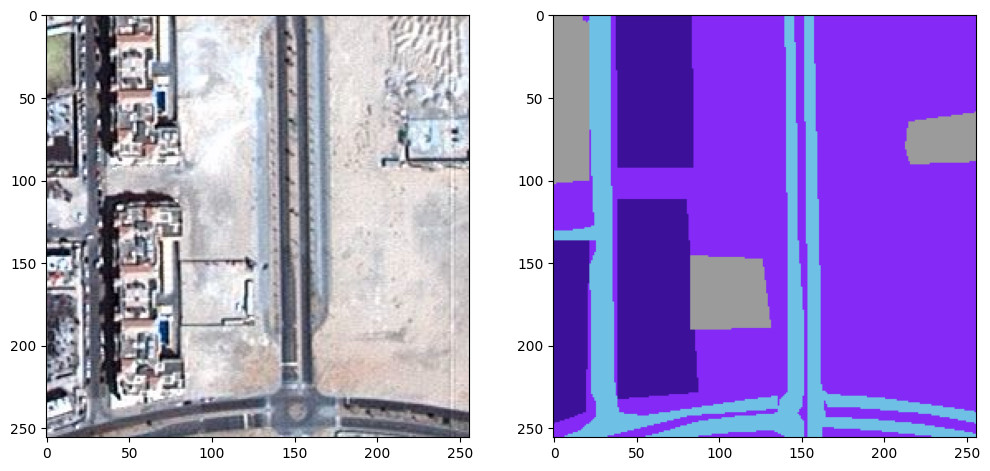

In [9]:
import random
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 3)))
plt.show()

# Converting HEX to RGB


**RGB to HEX: (Hexadecimel --> base 16)This number divided by sixteen (integer division; ignoring any remainder) givesthe first hexadecimal digit (between 0 and F, where the letters A to F representthe numbers 10 to 15). The remainder gives the second hexadecimal digit.**


*0-9 --> 0-9*

*10-15 --> A-F*


*Calculating RGB from HEX: #3C1098*

3C = 3x16 + 12 = 60

10 = 1x16 + 0 = 16

98 = 9x16 + 8 = 152

In [10]:
"""
HEX CODES for different classes in our dataset
Building           : #3C1098
Land (unpaved area): #8429F6
Road               : #6EC1E4
Vegetation         : #FEDD3A
Water              : #E2A929
Unlabeled          : #9B9B9B
"""

# These are the given HEX codes for 6 classes in the images
# Converting HEX to RGB
Building = "#3C1098".lstrip('#')
Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4)))

Land = "#8429F6".lstrip('#')
Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4)))

Road = "6EC1E4".lstrip('#')
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4)))

Vegetation = "FEDD3A".lstrip('#')
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4)))

Water = "E2A929".lstrip('#')
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4)))

Unlabeled = "#9B9B9B".lstrip('#')
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4)))

# **RGB to 2D Labels**

In [11]:
# Now replacing RGB to integer values to be used as labels.
# Finding pixels with combination of RGB for the above defined arrays.
# If matches then replacing all values with that pixels with that integer representing specific class

label = single_patch_mask
def rgb_to_2D_label(label): # Label represents a single mask patch in the form of a 3D NumPy array with RGB values for each pixel.

  """
  Supposed to replace RGB values with integers
  """
  label_seg = np.zeros(label.shape, dtype= int)
  label_seg[np.all(label == Building, axis=-1)] = 0
  label_seg[np.all(label == Land, axis=-1)] = 1
  label_seg[np.all(label == Road, axis=-1)] = 2
  label_seg[np.all(label == Vegetation, axis=-1)] = 3
  label_seg[np.all(label == Water, axis=-1)] = 4
  label_seg[np.all(label == Unlabeled, axis=-1)] = 5
    
  label_seg = label_seg[:, :, 0]
    
  return label_seg

In [12]:
labels = []
for i in range(mask_dataset.shape[0]):
  label = rgb_to_2D_label(mask_dataset[i])
  labels.append(label)
labels = np.array(labels)
labels = np.expand_dims(labels, axis=3)

print("Unique labels in label dataset are: ", np.unique(labels))

Unique labels in label dataset are:  [0 1 2 3 4 5]


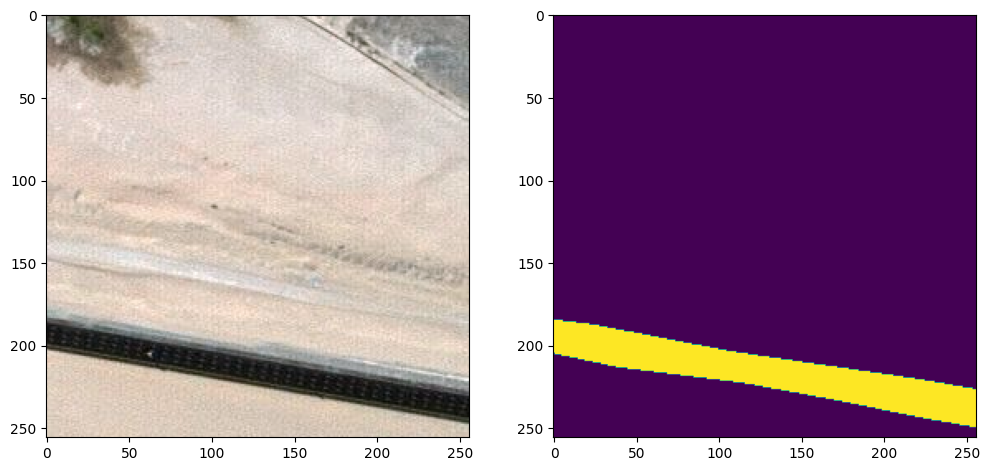

In [13]:
# Checking if there is any misalignment in patch images and masks.

image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()

# **Converting to one-hot encoded format**

In [14]:
n_classes = len(np.unique(labels))

# Converting into one-hot encoding format
# It helps the model to treat each class independently during training
from keras.utils import to_categorical  
labels_cat = to_categorical(labels, num_classes=n_classes)

# **Splitting the dataset**

In [15]:

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)

In [16]:
#from sklearn.utils.class_weight import compute_class_weight
#weights = compute_class_weight('balanced', np.unique(np.ravel(labels,order='C')),np.ravel(labels,order='C'))
#print(weights)

In [17]:
weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
dice_loss = sm.losses.DiceLoss(class_weights=weights) # Dice Loss is commonly used in segmentation tasks to address class imbalance and focuses on overlap between the predicted and ground truth masks.
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

In [18]:
"""
Standard Unet
Model isn't compiled here, instead will be done externally to make it
easy to test various loss functions and optimizers.
"""

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K

def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)



def multi_unet_model(n_classes=4, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
    # Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs
    # Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.2)(c1)  # Original 0.1
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2)  # Original 0.1
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)  # Original 0.1
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)  # Original 0.1
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
    model = Model(inputs=[inputs], outputs=[outputs])


    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    #model.summary()
    
    return model

In [19]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

In [20]:
print(f'Height of Image is : {IMG_HEIGHT}')
print(f'Width of Image is : {IMG_WIDTH}')
print(f'No of Channels in Image is : {IMG_CHANNELS}')

Height of Image is : 256
Width of Image is : 256
No of Channels in Image is : 3


# **Setting metrics**

In [21]:
#metrics = ['accuracy']
metrics = ['accuracy', jacard_coef]

In [22]:
def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

# **Model Compilation**

In [23]:
model = get_model()
model.compile(optimizer='adam', loss=total_loss, metrics=metrics)
# model.compile(optimizer='adam', loss = 'categocrical_crossentropy', metrics=metrics)

In [24]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [25]:
model_history = model.fit(X_train, y_train,
                    batch_size = 16,
                    verbose = 1,
                    epochs = 100,
                    validation_data = (X_test, y_test),
                    shuffle = False)

Epoch 1/100
66/66 [==============================] - 395s 6s/step - loss: 1.0010 - accuracy: 0.4912 - jacard_coef: 0.2395 - val_loss: 0.9987 - val_accuracy: 0.6085 - val_jacard_coef: 0.1863
Epoch 2/100
66/66 [==============================] - 384s 6s/step - loss: 0.9736 - accuracy: 0.6497 - jacard_coef: 0.3807 - val_loss: 1.0108 - val_accuracy: 0.5251 - val_jacard_coef: 0.2787
Epoch 3/100
66/66 [==============================] - 377s 6s/step - loss: 0.9552 - accuracy: 0.7193 - jacard_coef: 0.4666 - val_loss: 0.9912 - val_accuracy: 0.5812 - val_jacard_coef: 0.3449
Epoch 4/100
66/66 [==============================] - 374s 6s/step - loss: 0.9470 - accuracy: 0.7436 - jacard_coef: 0.5041 - val_loss: 1.0190 - val_accuracy: 0.5715 - val_jacard_coef: 0.3701
Epoch 5/100
66/66 [==============================] - 389s 6s/step - loss: 0.9425 - accuracy: 0.7576 - jacard_coef: 0.5295 - val_loss: 0.9862 - val_accuracy: 0.6056 - val_jacard_coef: 0.3916
Epoch 6/100
66/66 [==============================]

In [26]:
training_history = model_history

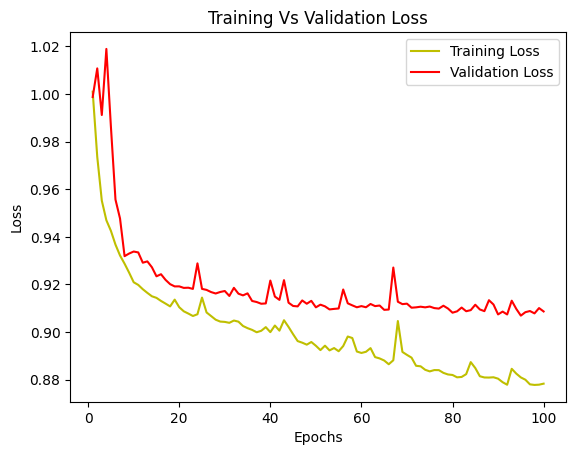

In [27]:
loss = training_history.history['loss']
val_loss = training_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label="Training Loss")
plt.plot(epochs, val_loss, 'r', label="Validation Loss")
plt.title("Training Vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

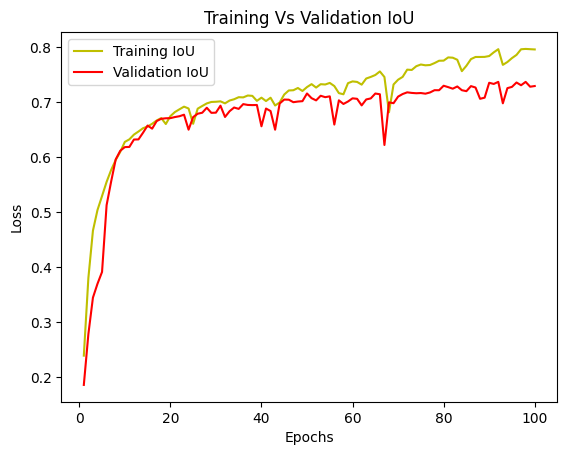

In [28]:
jacard_coef = training_history.history['jacard_coef']
val_jacard_coef = training_history.history['val_jacard_coef']

epochs = range(1, len(jacard_coef) + 1)
plt.plot(epochs, jacard_coef, 'y', label="Training IoU")
plt.plot(epochs, val_jacard_coef, 'r', label="Validation IoU")
plt.title("Training Vs Validation IoU")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [29]:
y_pred = model.predict(X_test)

9/9 [==============================] - 18s 2s/step


In [30]:
len(y_pred)

261

In [31]:
y_pred_argmax = np.argmax(y_pred, axis=3)

In [32]:
y_test_argmax = np.argmax(y_test, axis=3)

# **Prediction vs Actual**

In [33]:
import random

test_image_number = random.randint(0, len(X_test))

test_image = X_test[test_image_number]
ground_truth_image = y_test_argmax[test_image_number]

test_image_input = np.expand_dims(test_image, 0)

prediction = model.predict(test_image_input)
predicted_image = np.argmax(prediction, axis=3)
predicted_image = predicted_image[0,:,:]

1/1 [==============================] - 0s 83ms/step


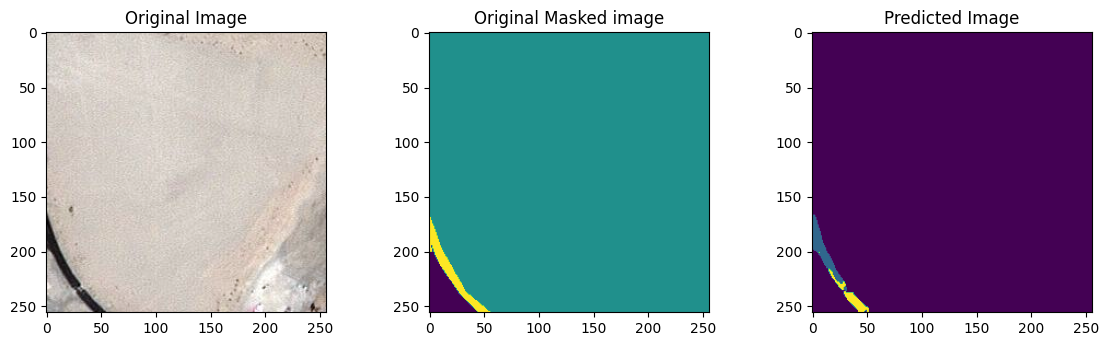

In [34]:
plt.figure(figsize=(14,8))
plt.subplot(231)
plt.title("Original Image")
plt.imshow(test_image)
plt.subplot(232)
plt.title("Original Masked image")
plt.imshow(ground_truth_image)
plt.subplot(233)
plt.title("Predicted Image")
plt.imshow(predicted_image)